In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [3]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

file_path = '/content/drive/MyDrive/THESIS/Train_model_Rome_Vince.csv'
full_train_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Valid_model_Rome_Vince.csv'
full_valid_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Test_model_Rome_Vince.csv'
full_test_data = pd.read_csv(file_path)

In [4]:
train_data = full_train_data.copy()
val_data = full_valid_data.copy()
test_data = full_test_data.copy()

# Preprocess function
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    return data

train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)

This section describes the creation of the LSTM model. Only the 'id,' 'date,' and 'price' columns are used here. The model then creates sequences of historical prices to learn temporal features that can contribute to predictive performance. The model is also hyperparameter-tuned using Optuna. Two additional variables that are tuned, besides the hyperparameters of the LSTM model itself, are 'sequence_length' and 'max_instances_per_location.'

The sequence length determines the size of the price sequences used to learn features. The max_instances_per_location parameter selects a certain number of random historical prices per unique location since using all historical prices would require too much computational power. The learned features are extracted, and the model is saved for later reuse. The max_instances_per_location is set to 100, as this has already been adjusted in the dataset, but it is kept in place just in case.

In [ ]:
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

# Sequence creation function
def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(sequence_length, len(group)):
            seq = group.iloc[i-sequence_length:i]
            sequences.append(seq)
            labels.append(group.iloc[i]['price'])  # Correct label
            ids.append(id)
    return sequences, labels, ids

# Define the objective function for Optuna
def objective(trial):
    sequence_length = trial.suggest_int('sequence_length', 7, 14)
    max_instances_per_location = trial.suggest_int('max_instances_per_location', 100, 100, step=25)

    train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, sequence_length, max_instances_per_location)
    val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, sequence_length, max_instances_per_location)
    test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, sequence_length, max_instances_per_location)

    X_train = np.array([seq[['price']].values for seq in train_sequences])
    y_train = np.array(train_labels)
    X_val = np.array([seq[['price']].values for seq in val_sequences])
    y_val = np.array(val_labels)
    X_test = np.array([seq[['price']].values for seq in test_sequences])
    y_test = np.array(test_labels)

    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units1', 32, 128, step=32),
                   return_sequences=True,
                   input_shape=(sequence_length, 1), activation='relu'))
    model.add(Dropout(rate=trial.suggest_float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(LSTM(units=trial.suggest_int('units2', 32, 128, step=32), return_sequences=False, activation='relu'))
    model.add(Dropout(rate=trial.suggest_float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(16))
    model.add(Dense(1))

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mse'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping], verbose=0)

    val_loss = min(history.history['val_loss'])

    # Save the model
    model_save_path = os.path.join(drive_path, f'model_trial_{trial.number}.h5')
    model.save(model_save_path)

    return val_loss

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial

# Extract the best hyperparameters
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']
best_units1 = best_trial.params['units1']
best_units2 = best_trial.params['units2']
best_dropout1 = best_trial.params['dropout1']
best_dropout2 = best_trial.params['dropout2']
best_learning_rate = best_trial.params['learning_rate']

# Recreate sequences with the best sequence length
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Build the final model using the best hyperparameters
input_layer = Input(shape=(best_sequence_length, 1))
lstm_layer_1 = LSTM(units=best_units1, return_sequences=True, activation='relu')(input_layer)
dropout_layer_1 = Dropout(rate=best_dropout1)(lstm_layer_1)
lstm_layer_2 = LSTM(units=best_units2, return_sequences=False, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(rate=best_dropout2)(lstm_layer_2)
dense_layer = Dense(16)(dropout_layer_2)
output_layer = Dense(1)(dense_layer)

feature_extraction_model = Model(inputs=input_layer, outputs=dense_layer)
prediction_model = Model(inputs=input_layer, outputs=output_layer)
prediction_model.compile(optimizer=Adam(learning_rate=best_learning_rate),
                         loss='mean_squared_error',
                         metrics=['mse'])

history = prediction_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32)

# Save the final model
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_ROME_FINAL.h5')
prediction_model.save(final_model_path)

feature_model_path = os.path.join(drive_path, 'LSTM_FEATURES_ROME_FINAL.h5')
feature_extraction_model.save(feature_model_path)

train_features_lstm = feature_extraction_model.predict(X_train)
val_features_lstm = feature_extraction_model.predict(X_val)
test_features_lstm = feature_extraction_model.predict(X_test)

# Optional: Save the Optuna study
study_path = os.path.join(drive_path, 'optuna_study_LSTM_ROME_FINAL.pkl')
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

# Optional: Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)


The LSTM model can be reloaded here.


In [ ]:
import os
from tensorflow.keras.models import load_model
import joblib
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

# Custom LSTM without the 'time_major' argument
class CustomLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        # Remove time_major if it exists in kwargs
        kwargs.pop('time_major', None)
        super(CustomLSTM, self).__init__(*args, **kwargs)

# Mapping the custom class
custom_objects = {'LSTM': CustomLSTM}

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

feature_model_path = os.path.join(drive_path, 'LSTM_FEATURES_ROME_FINAL.h5')
study_path = os.path.join(drive_path, 'optuna_study_LSTM_ROME_FINAL.pkl')

# Load the model

extraction_model = load_model(feature_model_path, custom_objects=custom_objects)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Assuming the loaded model is the feature extraction model
train_features_lstm = extraction_model.predict(X_train)
val_features_lstm = extraction_model.predict(X_val)
test_features_lstm = extraction_model.predict(X_test)



Creating sequences: 100%|██████████| 2000/2000 [00:06<00:00, 317.67it/s]


15179/15179 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Here, the LSTM model can be reloaded to make price predictions.

In [7]:
import os
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_ROME_FINAL.h5')
study_path = os.path.join(drive_path, 'optuna_study_LSTM_ROME_FINAL.pkl')

# Load the model
loaded_model = load_model(final_model_path)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length]['price'])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Evaluate the model on the test set
evaluation = loaded_model.evaluate(X_test, y_test, verbose=2)

# Make predictions on the test set
y_test_pred = loaded_model.predict(X_test)

# Inverse transform the predictions and true values
y_test_pred_unscaled = scaler.inverse_transform(y_test_pred)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate and display the MSE, MAE, and R-squared metrics
mse = mean_squared_error(y_test_unscaled, y_test_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_test_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_test_pred_unscaled)
avg_residuals = np.mean(y_test_unscaled - y_test_pred_unscaled)

print("Evaluation - Loss, MSE, MAE:", evaluation)
print("Manual Calculation - Mean Squared Error (MSE):", mse)
print("Manual Calculation - Mean Absolute Error (MAE):", mae)
print("Manual Calculation - R-squared:", r2)
print("Manual Calculation - Average Residuals:", avg_residuals)

Creating sequences: 100%|██████████| 2000/2000 [00:07<00:00, 274.79it/s]


1438/1438 - 3s - 2ms/step - loss: 0.0674 - mean_squared_error: 0.0674
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Evaluation - Loss, MSE, MAE: [0.06738051027059555, 0.06738051027059555]
Manual Calculation - Mean Squared Error (MSE): 486.82390664987275
Manual Calculation - Mean Absolute Error (MAE): 5.703559281058934
Manual Calculation - R-squared: 0.9843471823310186
Manual Calculation - Average Residuals: -2.2861077910713528


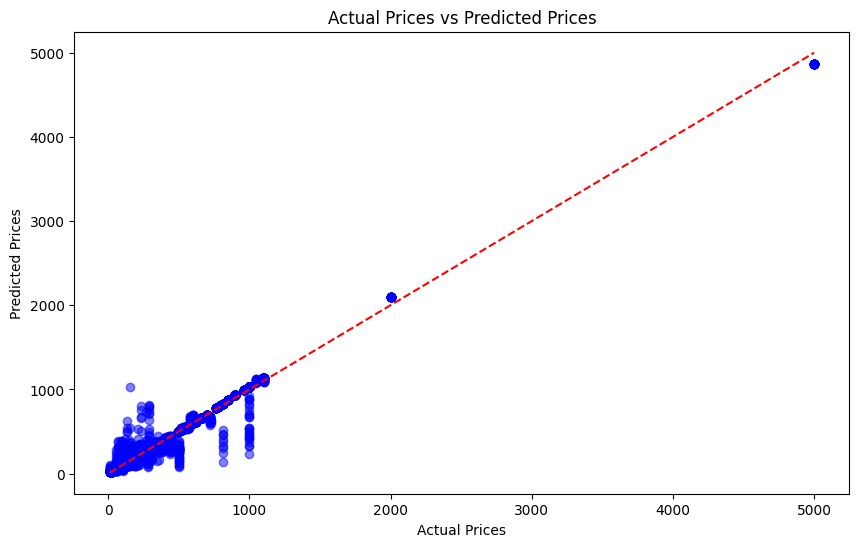

In [8]:
# Plotting actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_unscaled, y_test_pred_unscaled, color='blue', alpha=0.5)
plt.plot([min(y_test_unscaled), max(y_test_unscaled)], [min(y_test_unscaled), max(y_test_unscaled)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual Prices vs Predicted Prices')

plt.show()

In [ ]:
# Unscaling the datasets
train_data_lstm_unscaled = train_data_lstm.copy()
train_data_lstm_unscaled['price'] = scaler.inverse_transform(train_data_lstm[['price']])

val_data_lstm_unscaled = val_data_lstm.copy()
val_data_lstm_unscaled['price'] = scaler.inverse_transform(val_data_lstm[['price']])

test_data_lstm_unscaled = test_data_lstm.copy()
test_data_lstm_unscaled['price'] = scaler.inverse_transform(test_data_lstm[['price']])




Code to correctly merge the LSTM features with the original data.

In [35]:
train_features_lstm = scaler.inverse_transform(train_features_lstm)
val_features_lstm = scaler.inverse_transform(val_features_lstm)
test_features_lstm = scaler.inverse_transform(test_features_lstm)

In [36]:
# Convert the extracted features and IDs into DataFrames with clean integer IDs
train_features_with_ids = pd.DataFrame(train_features_lstm)
train_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in train_ids]

val_features_with_ids = pd.DataFrame(val_features_lstm)
val_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in val_ids]

test_features_with_ids = pd.DataFrame(test_features_lstm)
test_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in test_ids]

# Now train_features_with_ids, val_features_with_ids, and test_features_with_ids contain the LSTM features and their associated integer IDs


In [37]:
# Extract the last occurrence of each ID's features
def extract_last_features(features, ids):
    last_features_map = {}
    for idx, id in enumerate(ids):
        last_features_map[id] = features[idx]
    unique_ids = list(last_features_map.keys())
    last_features = np.array([last_features_map[id] for id in unique_ids])
    return last_features, unique_ids

# Apply extraction of the last features
train_last_features, train_unique_ids = extract_last_features(train_features_lstm, train_ids)
val_last_features, val_unique_ids = extract_last_features(val_features_lstm, val_ids)
test_last_features, test_unique_ids = extract_last_features(test_features_lstm, test_ids)

# Convert to DataFrames
train_features_with_ids_last = pd.DataFrame(train_last_features)
train_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in train_unique_ids]

val_features_with_ids_last = pd.DataFrame(val_last_features)
val_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in val_unique_ids]

test_features_with_ids_last = pd.DataFrame(test_last_features)
test_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in test_unique_ids]

In this step, the data is preprocessed for the PE-GNN model. Since historical prices are no longer needed, only one data entry is kept for each unique Airbnb listing. The coordinates are then extracted to be used in the position encoder, and the other hedonic features are combined with the learned LSTM features to be added to the nodes of the GNN. Additionally, it is ensured that the spatial and temporal features, which are used for the baseline models, are removed from the data

In [38]:
import pandas as pd

# Preprocess PE-GNN data and take the last instance for each id
def preprocess_pegnn_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    data = data.drop_duplicates(subset=['id'], keep='last')
    return data

train_data_pegnn = preprocess_pegnn_data(train_data.copy())
val_data_pegnn = preprocess_pegnn_data(val_data.copy())
test_data_pegnn = preprocess_pegnn_data(test_data.copy())



In [39]:

import pandas as pd

# Assume train_data_pegnn, val_data_pegnn, and test_data_pegnn are already loaded and contain the 'id' column

# Ensure IDs are consistent and merge the datasets
train_data_pegnn['id'] = train_data_pegnn['id'].astype(int)
val_data_pegnn['id'] = val_data_pegnn['id'].astype(int)
test_data_pegnn['id'] = test_data_pegnn['id'].astype(int)

train_features_with_ids_last['id'] = train_features_with_ids_last['id'].astype(int)
val_features_with_ids_last['id'] = val_features_with_ids_last['id'].astype(int)
test_features_with_ids_last['id'] = test_features_with_ids_last['id'].astype(int)

# Merge the LSTM features with the original data
train_data_pegnn = pd.merge(train_data_pegnn, train_features_with_ids_last, on='id', how='left')
val_data_pegnn = pd.merge(val_data_pegnn, val_features_with_ids_last, on='id', how='left')
test_data_pegnn = pd.merge(test_data_pegnn, test_features_with_ids_last, on='id', how='left')


In [40]:
from sklearn.preprocessing import StandardScaler, RobustScaler
# Extract features
def extract_features(data):
    coordinates = data[['latitude', 'longitude']].to_numpy()
    # Dropping unnecessary columns including the specified features
    #features = data
    features = data.drop(columns=[
    'nearby_airbnbs_count', 'nearby_restaurants_bars', 'nearby_transport', 'mean_price_neighbors',
    'latitude', 'longitude', 'date', 'id', 'host_id',
    "nearby_restaurants_bars", "nearby_transport",
    "mean_price_neighbors",
    "nearby_airbnbs_count",
    "neighbourhood_I Centro Storico",
    "neighbourhood_II Parioli/Nomentano",
    "neighbourhood_III Monte Sacro",
    "neighbourhood_IV Tiburtina", "neighbourhood_IX Eur",
    "neighbourhood_V Prenestino/Centocelle",
    "neighbourhood_VI Roma delle Torri",
    "neighbourhood_VII San Giovanni/Cinecittà",
    "neighbourhood_VIII Appia Antica",
    "neighbourhood_X Ostia/Acilia",
    "neighbourhood_XI Arvalia/Portuense",
    "neighbourhood_XII Monte Verde",
    "neighbourhood_XIII Aurelia",
    "neighbourhood_XIV Monte Mario",
    "neighbourhood_XV Cassia/Flaminia",
    "season_Autumn",
     "is_holiday", "is_school_holiday"])


    for col in features.select_dtypes(include=['object']).columns:
        features[col] = features[col].astype('category').cat.codes
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
    features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
    non_numeric_cols = features.select_dtypes(exclude=[np.number]).columns.tolist()
    features = features.select_dtypes(include=[np.number])
    print("Dropped non-numeric features:", non_numeric_cols)

    features.columns = features.columns.astype(str)
    return coordinates, features



# Extracting features for train, validation, and test sets
train_coords_pegnn, train_features_pegnn = extract_features(train_data_pegnn)
val_coords_pegnn, val_features_pegnn = extract_features(val_data_pegnn)
test_coords_pegnn, test_features_pegnn = extract_features(test_data_pegnn)

train_prices_pegnn = train_features_pegnn['price'].values
val_prices_pegnn = val_features_pegnn['price'].values
test_prices_pegnn = test_features_pegnn['price'].values



# Scaling combined features
scaler = RobustScaler()
train_features_pegnn = pd.DataFrame(scaler.fit_transform(train_features_pegnn), columns=train_features_pegnn.columns)
val_features_pegnn = pd.DataFrame(scaler.transform(val_features_pegnn), columns=val_features_pegnn.columns)
test_features_pegnn = pd.DataFrame(scaler.transform(test_features_pegnn), columns=test_features_pegnn.columns)

# Initialize and fit the RobustScaler on the training prices
scaler = RobustScaler()
train_prices_pegnn_scaled = scaler.fit_transform(train_prices_pegnn.reshape(-1, 1))
val_prices_pegnn_scaled = scaler.transform(val_prices_pegnn.reshape(-1, 1))
test_prices_pegnn_scaled = scaler.transform(test_prices_pegnn.reshape(-1, 1))


# Convert the scaled prices to PyTorch tensors
y_train = torch.tensor(train_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)


# Extract and scale prices
#train_prices_pegnn = train_features_pegnn['price']
#val_prices_pegnn = val_features_pegnn['price']
#test_prices_pegnn = test_features_pegnn['price']


<ipython-input-40-471186034b60>:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-40-471186034b60>:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-40-471186034b60>:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)


Dropped non-numeric features: []
Dropped non-numeric features: []
Dropped non-numeric features: []


In [41]:
train_features_pegnn.head()

,available,price,host_response_time,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,...,6,7,8,9,10,11,12,13,14,15
0,1.0,-0.797508,-0.5,0.0,1.25,0.8,0.0,-1.0,0.5,0.0,...,-0.759622,-0.521367,1.104971,0.840409,0.871620,-0.559776,0.715581,0.550908,-0.981654,-1.041105
1,1.0,-0.049844,-0.5,1.0,0.75,1.6,0.0,0.5,0.0,0.0,...,-0.100520,-0.078117,0.111204,0.107356,0.120957,-0.126243,0.115982,0.121849,-0.017849,-0.162569
2,1.0,0.012461,-0.5,0.0,-0.25,-0.2,0.0,1.0,0.0,1.0,...,-0.118354,-0.086712,0.110873,0.117848,0.127022,-0.155874,0.112623,0.134118,-0.029132,-0.157087
3,0.0,-0.236760,0.0,0.0,2.25,1.6,0.0,1.5,0.0,1.0,...,-0.259487,-0.203535,0.308788,0.269929,0.298140,-0.322235,0.283013,0.284140,-0.263510,-0.402538
4,0.0,-0.299065,0.0,1.0,0.75,0.4,0.0,0.0,0.0,0.0,...,0.242363,0.242059,-0.353748,-0.269677,-0.277589,0.368056,-0.274772,-0.312536,0.564031,0.395220


to save the dataset with lstm features

In [ ]:
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
train_data_pegnn.to_csv(path + 'train_data_lstm_rome_FINAL.csv', index=False)
val_data_pegnn.to_csv(path + 'val_data_lstm_rome_FINAL.csv', index=False)
test_data_pegnn.to_csv(path + 'test_data_lstm_rome_FINAL.csv', index=False)

This section describes the creation of the PE-GNN model. It also includes the functionality to save the model and reuse it later. The edges of the GNN are created using a k-nearest neighbors approach, where edges are formed between the x number of closest neighbors in terms of physical distance. The number of nearest neighbors, along with several other variables, is hyperparameter-tuned using Optuna.

The position encoder learns by utilizing the coordinates of the nodes and adds this information to the nodes. As a result, the nodes contain information about the spatial aspect through the PE, the temporal aspect through the LSTM, and the hedonic features. This model also provides various performance metrics, which can be viewed below, along with several plots to track the evolution of these metrics throughout the learning process.

[I 2024-08-13 15:34:46,112] A new study created in memory with name: no-name-4c9d96ee-69b7-4f6f-816f-5803623e52ba
Training PEGNN: 100%|██████████| 50/50 [00:07<00:00,  6.33it/s]
[I 2024-08-13 15:34:54,320] Trial 0 finished with value: 0.15602293610572815 and parameters: {'hidden_channels': 82, 'lr': 0.0024891275553607464, 'k': 9, 'dropout_rate': 0.39074564051013416}. Best is trial 0 with value: 0.15602293610572815.
Training PEGNN: 100%|██████████| 50/50 [01:50<00:00,  2.21s/it]
[I 2024-08-13 15:36:49,755] Trial 1 finished with value: 0.15550781786441803 and parameters: {'hidden_channels': 119, 'lr': 0.00966592305040517, 'k': 104, 'dropout_rate': 0.2752371064506161}. Best is trial 1 with value: 0.15550781786441803.
Training PEGNN: 100%|██████████| 50/50 [00:09<00:00,  5.19it/s]
[I 2024-08-13 15:36:59,756] Trial 2 finished with value: 0.20884597301483154 and parameters: {'hidden_channels': 93, 'lr': 0.008833143561647465, 'k': 11, 'dropout_rate': 0.36576177675318433}. Best is trial 1 with

Best parameters:  {'hidden_channels': 61, 'lr': 0.001111180665444211, 'k': 56, 'dropout_rate': 0.23842939545890193}


Final training:   0%|          | 1/500 [00:01<09:43,  1.17s/it]

Epoch 1, Training Loss: 6.70020055770874, Training R-squared: -0.09601249229240416, Training MAE: 0.9528090953826904, Training MSE: 6.700200080871582
Epoch 1, Validation Loss: 10.335530281066895, Validation R-squared: -0.03987046717457443, Validation MAE: 1.0338612794876099, Validation MSE: 10.335531234741211


Final training:   0%|          | 2/500 [00:02<09:45,  1.17s/it]

Epoch 2, Training Loss: 6.421168804168701, Training R-squared: -0.0503688247905405, Training MAE: 0.9248053431510925, Training MSE: 6.421168804168701
Epoch 2, Validation Loss: 9.964539527893066, Validation R-squared: -0.0025445464133277973, Validation MAE: 1.0155726671218872, Validation MSE: 9.964539527893066


Final training:   1%|          | 3/500 [00:03<09:44,  1.18s/it]

Epoch 3, Training Loss: 6.150230407714844, Training R-squared: -0.006048973429298776, Training MAE: 0.9093180298805237, Training MSE: 6.1502299308776855
Epoch 3, Validation Loss: 9.594688415527344, Validation R-squared: 0.034666577026188694, Validation MAE: 1.002163290977478, Validation MSE: 9.594688415527344


Final training:   1%|          | 4/500 [00:04<09:49,  1.19s/it]

Epoch 4, Training Loss: 5.980994701385498, Training R-squared: 0.02163435001890912, Training MAE: 0.8960590958595276, Training MSE: 5.980994701385498
Epoch 4, Validation Loss: 9.208961486816406, Validation R-squared: 0.07347504471498723, Validation MAE: 0.9924198985099792, Validation MSE: 9.208961486816406


Final training:   1%|          | 5/500 [00:05<09:42,  1.18s/it]

Epoch 5, Training Loss: 5.7481184005737305, Training R-squared: 0.059728021393850805, Training MAE: 0.8875659704208374, Training MSE: 5.748119354248047
Epoch 5, Validation Loss: 8.820369720458984, Validation R-squared: 0.11257167762686182, Validation MAE: 0.9871416687965393, Validation MSE: 8.820369720458984


Final training:   1%|          | 6/500 [00:07<09:39,  1.17s/it]

Epoch 6, Training Loss: 5.494225025177002, Training R-squared: 0.10125971481779383, Training MAE: 0.8851591944694519, Training MSE: 5.494225025177002
Epoch 6, Validation Loss: 8.418652534484863, Validation R-squared: 0.1529889819318634, Validation MAE: 0.9887115359306335, Validation MSE: 8.418652534484863


Final training:   1%|▏         | 7/500 [00:08<09:36,  1.17s/it]

Epoch 7, Training Loss: 5.314630508422852, Training R-squared: 0.13063771603160357, Training MAE: 0.8931514620780945, Training MSE: 5.314630031585693
Epoch 7, Validation Loss: 8.01584243774414, Validation R-squared: 0.19351619740982162, Validation MAE: 0.9969017505645752, Validation MSE: 8.01584243774414


Final training:   2%|▏         | 8/500 [00:09<09:36,  1.17s/it]

Epoch 8, Training Loss: 5.0309672355651855, Training R-squared: 0.17703895436818595, Training MAE: 0.9017850756645203, Training MSE: 5.0309672355651855
Epoch 8, Validation Loss: 7.6094207763671875, Validation R-squared: 0.2344067857129165, Validation MAE: 1.0097304582595825, Validation MSE: 7.6094207763671875


Final training:   2%|▏         | 9/500 [00:10<09:33,  1.17s/it]

Epoch 9, Training Loss: 4.910633563995361, Training R-squared: 0.19672308402683625, Training MAE: 0.9267909526824951, Training MSE: 4.910633563995361
Epoch 9, Validation Loss: 7.196089744567871, Validation R-squared: 0.275992498233676, Validation MAE: 1.018027663230896, Validation MSE: 7.196090221405029


Final training:   2%|▏         | 10/500 [00:11<09:31,  1.17s/it]

Epoch 10, Training Loss: 4.585013389587402, Training R-squared: 0.2499877789709667, Training MAE: 0.9411848783493042, Training MSE: 4.585012912750244
Epoch 10, Validation Loss: 6.777565002441406, Validation R-squared: 0.3181008491410424, Validation MAE: 1.0105875730514526, Validation MSE: 6.7775654792785645


Final training:   2%|▏         | 11/500 [00:12<09:28,  1.16s/it]

Epoch 11, Training Loss: 4.515006065368652, Training R-squared: 0.2614395433242028, Training MAE: 0.948316752910614, Training MSE: 4.515005588531494
Epoch 11, Validation Loss: 6.342726707458496, Validation R-squared: 0.3618504052792819, Validation MAE: 0.9811108112335205, Validation MSE: 6.342726707458496


Final training:   2%|▏         | 12/500 [00:14<09:25,  1.16s/it]

Epoch 12, Training Loss: 4.267171382904053, Training R-squared: 0.3019799986160119, Training MAE: 0.9322407245635986, Training MSE: 4.267171859741211
Epoch 12, Validation Loss: 5.888453960418701, Validation R-squared: 0.4075553909471964, Validation MAE: 0.9277435541152954, Validation MSE: 5.888453483581543


Final training:   3%|▎         | 13/500 [00:15<09:30,  1.17s/it]

Epoch 13, Training Loss: 4.015155792236328, Training R-squared: 0.34320444903323954, Training MAE: 0.8850004076957703, Training MSE: 4.015156269073486
Epoch 13, Validation Loss: 5.420440196990967, Validation R-squared: 0.45464278857965534, Validation MAE: 0.853065013885498, Validation MSE: 5.420441627502441


Final training:   3%|▎         | 14/500 [00:16<09:32,  1.18s/it]

Epoch 14, Training Loss: 3.7223477363586426, Training R-squared: 0.3911018314274991, Training MAE: 0.825140118598938, Training MSE: 3.7223477363586426
Epoch 14, Validation Loss: 4.94481897354126, Validation R-squared: 0.5024957000508924, Validation MAE: 0.763046383857727, Validation MSE: 4.944818496704102


Final training:   3%|▎         | 15/500 [00:17<09:35,  1.19s/it]

Epoch 15, Training Loss: 3.577035903930664, Training R-squared: 0.4148717985665473, Training MAE: 0.7582551836967468, Training MSE: 3.577035427093506
Epoch 15, Validation Loss: 4.472245216369629, Validation R-squared: 0.5500418923087342, Validation MAE: 0.6667546629905701, Validation MSE: 4.472245216369629


Final training:   3%|▎         | 16/500 [00:18<09:30,  1.18s/it]

Epoch 16, Training Loss: 3.3332509994506836, Training R-squared: 0.4547498368211531, Training MAE: 0.6928293704986572, Training MSE: 3.3332512378692627
Epoch 16, Validation Loss: 4.009077072143555, Validation R-squared: 0.5966418468996758, Validation MAE: 0.5764806866645813, Validation MSE: 4.0090765953063965


Final training:   3%|▎         | 17/500 [00:19<09:27,  1.18s/it]

Epoch 17, Training Loss: 3.1111347675323486, Training R-squared: 0.4910834373160152, Training MAE: 0.6329436898231506, Training MSE: 3.1111347675323486
Epoch 17, Validation Loss: 3.55715274810791, Validation R-squared: 0.6421104483767122, Validation MAE: 0.5124708414077759, Validation MSE: 3.5571532249450684


Final training:   4%|▎         | 18/500 [00:21<09:23,  1.17s/it]

Epoch 18, Training Loss: 2.9976933002471924, Training R-squared: 0.5096400965836968, Training MAE: 0.6014491319656372, Training MSE: 2.9976933002471924
Epoch 18, Validation Loss: 3.1165735721588135, Validation R-squared: 0.6864377071827897, Validation MAE: 0.4803946912288666, Validation MSE: 3.1165735721588135


Final training:   4%|▍         | 19/500 [00:22<09:20,  1.17s/it]

Epoch 19, Training Loss: 2.825401782989502, Training R-squared: 0.5378233395918783, Training MAE: 0.5942115187644958, Training MSE: 2.825401782989502
Epoch 19, Validation Loss: 2.6808629035949707, Validation R-squared: 0.7302750861076815, Validation MAE: 0.4641576409339905, Validation MSE: 2.68086314201355


Final training:   4%|▍         | 20/500 [00:23<09:18,  1.16s/it]

Epoch 20, Training Loss: 2.504384756088257, Training R-squared: 0.5903350446159346, Training MAE: 0.5902606844902039, Training MSE: 2.504384756088257
Epoch 20, Validation Loss: 2.244802474975586, Validation R-squared: 0.7741476659704852, Validation MAE: 0.44742000102996826, Validation MSE: 2.244802236557007


Final training:   4%|▍         | 21/500 [00:24<09:15,  1.16s/it]

Epoch 21, Training Loss: 2.3662030696868896, Training R-squared: 0.6129386441899684, Training MAE: 0.5968803763389587, Training MSE: 2.366203546524048
Epoch 21, Validation Loss: 1.8314658403396606, Validation R-squared: 0.8157339693234382, Validation MAE: 0.42626839876174927, Validation MSE: 1.8314656019210815


Final training:   4%|▍         | 22/500 [00:25<09:15,  1.16s/it]

Epoch 22, Training Loss: 2.15042781829834, Training R-squared: 0.648235028195888, Training MAE: 0.5996626615524292, Training MSE: 2.15042781829834
Epoch 22, Validation Loss: 1.4633784294128418, Validation R-squared: 0.8527676813302043, Validation MAE: 0.4065638482570648, Validation MSE: 1.4633784294128418


Final training:   5%|▍         | 23/500 [00:26<09:15,  1.16s/it]

Epoch 23, Training Loss: 2.0158894062042236, Training R-squared: 0.6702426000778134, Training MAE: 0.621271550655365, Training MSE: 2.015889883041382
Epoch 23, Validation Loss: 1.1534806489944458, Validation R-squared: 0.8839468989191609, Validation MAE: 0.38999298214912415, Validation MSE: 1.1534806489944458


Final training:   5%|▍         | 24/500 [00:28<09:19,  1.17s/it]

Epoch 24, Training Loss: 2.0441629886627197, Training R-squared: 0.6656176476731825, Training MAE: 0.6189072132110596, Training MSE: 2.044163465499878
Epoch 24, Validation Loss: 0.9026010036468506, Validation R-squared: 0.9091881885169397, Validation MAE: 0.375336617231369, Validation MSE: 0.9026011228561401


Final training:   5%|▌         | 25/500 [00:29<09:21,  1.18s/it]

Epoch 25, Training Loss: 1.6831691265106201, Training R-squared: 0.7246687465119803, Training MAE: 0.61259526014328, Training MSE: 1.6831691265106201
Epoch 25, Validation Loss: 0.7051833271980286, Validation R-squared: 0.9290506388602889, Validation MAE: 0.36740630865097046, Validation MSE: 0.7051832675933838


Final training:   5%|▌         | 26/500 [00:30<09:18,  1.18s/it]

Epoch 26, Training Loss: 1.6941524744033813, Training R-squared: 0.7228720976895346, Training MAE: 0.602599024772644, Training MSE: 1.6941524744033813
Epoch 26, Validation Loss: 0.5609039664268494, Validation R-squared: 0.9435667571278262, Validation MAE: 0.3706927001476288, Validation MSE: 0.5609039664268494


Final training:   5%|▌         | 27/500 [00:31<09:14,  1.17s/it]

Epoch 27, Training Loss: 1.7285192012786865, Training R-squared: 0.7172504165549023, Training MAE: 0.6122947335243225, Training MSE: 1.7285192012786865
Epoch 27, Validation Loss: 0.46449416875839233, Validation R-squared: 0.9532666692912284, Validation MAE: 0.38222596049308777, Validation MSE: 0.4644941985607147


Final training:   6%|▌         | 28/500 [00:32<09:11,  1.17s/it]

Epoch 28, Training Loss: 1.5630937814712524, Training R-squared: 0.744310577568751, Training MAE: 0.6068193912506104, Training MSE: 1.5630937814712524
Epoch 28, Validation Loss: 0.4036753475666046, Validation R-squared: 0.9593857248459317, Validation MAE: 0.3900679051876068, Validation MSE: 0.4036753475666046


Final training:   6%|▌         | 29/500 [00:33<09:11,  1.17s/it]

Epoch 29, Training Loss: 1.5075169801712036, Training R-squared: 0.7534017733544742, Training MAE: 0.6057705879211426, Training MSE: 1.5075169801712036
Epoch 29, Validation Loss: 0.3591420352458954, Validation R-squared: 0.9638662802132768, Validation MAE: 0.38627296686172485, Validation MSE: 0.3591420352458954


Final training:   6%|▌         | 30/500 [00:35<09:08,  1.17s/it]

Epoch 30, Training Loss: 1.6095941066741943, Training R-squared: 0.7367040640260416, Training MAE: 0.5965148210525513, Training MSE: 1.6095942258834839
Epoch 30, Validation Loss: 0.3241877555847168, Validation R-squared: 0.9673830752441337, Validation MAE: 0.3678893446922302, Validation MSE: 0.3241877257823944


Final training:   6%|▌         | 31/500 [00:36<09:07,  1.17s/it]

Epoch 31, Training Loss: 1.4804656505584717, Training R-squared: 0.757826759861608, Training MAE: 0.580600917339325, Training MSE: 1.4804657697677612
Epoch 31, Validation Loss: 0.29594165086746216, Validation R-squared: 0.9702249470803231, Validation MAE: 0.34059712290763855, Validation MSE: 0.29594165086746216


Final training:   6%|▋         | 32/500 [00:37<09:03,  1.16s/it]

Epoch 32, Training Loss: 1.5186048746109009, Training R-squared: 0.7515879976840038, Training MAE: 0.5676813125610352, Training MSE: 1.5186049938201904
Epoch 32, Validation Loss: 0.2724989652633667, Validation R-squared: 0.9725835437437713, Validation MAE: 0.31531351804733276, Validation MSE: 0.2724989652633667


Final training:   7%|▋         | 33/500 [00:38<09:03,  1.16s/it]

Epoch 33, Training Loss: 1.6273263692855835, Training R-squared: 0.7338034794715006, Training MAE: 0.5384361743927002, Training MSE: 1.6273261308670044
Epoch 33, Validation Loss: 0.25426173210144043, Validation R-squared: 0.9744184150138616, Validation MAE: 0.29637885093688965, Validation MSE: 0.25426173210144043


Final training:   7%|▋         | 34/500 [00:39<09:01,  1.16s/it]

Epoch 34, Training Loss: 1.3910949230194092, Training R-squared: 0.772445984659248, Training MAE: 0.5204799175262451, Training MSE: 1.39109468460083
Epoch 34, Validation Loss: 0.23649178445339203, Validation R-squared: 0.9762062693801875, Validation MAE: 0.287392258644104, Validation MSE: 0.23649179935455322


Final training:   7%|▋         | 35/500 [00:40<09:05,  1.17s/it]

Epoch 35, Training Loss: 1.527563452720642, Training R-squared: 0.7501225704820258, Training MAE: 0.5087472200393677, Training MSE: 1.527563452720642
Epoch 35, Validation Loss: 0.2202533781528473, Validation R-squared: 0.9778400365652307, Validation MAE: 0.2854858934879303, Validation MSE: 0.22025339305400848


Final training:   7%|▋         | 36/500 [00:42<09:10,  1.19s/it]

Epoch 36, Training Loss: 1.5760093927383423, Training R-squared: 0.7421978222669658, Training MAE: 0.4935205578804016, Training MSE: 1.5760093927383423
Epoch 36, Validation Loss: 0.20840436220169067, Validation R-squared: 0.9790321814627799, Validation MAE: 0.287534236907959, Validation MSE: 0.20840434730052948


Final training:   7%|▋         | 37/500 [00:43<09:06,  1.18s/it]

Epoch 37, Training Loss: 1.3736255168914795, Training R-squared: 0.7753035988824855, Training MAE: 0.4868638515472412, Training MSE: 1.373625636100769
Epoch 37, Validation Loss: 0.20034922659397125, Validation R-squared: 0.9798426156511034, Validation MAE: 0.2910366952419281, Validation MSE: 0.20034924149513245


Final training:   8%|▊         | 38/500 [00:44<09:03,  1.18s/it]

Epoch 38, Training Loss: 1.3697980642318726, Training R-squared: 0.7759296932013902, Training MAE: 0.47742825746536255, Training MSE: 1.3697980642318726
Epoch 38, Validation Loss: 0.19680878520011902, Validation R-squared: 0.9801988262915657, Validation MAE: 0.2952740788459778, Validation MSE: 0.19680877029895782


Final training:   8%|▊         | 39/500 [00:45<08:58,  1.17s/it]

Epoch 39, Training Loss: 1.3987610340118408, Training R-squared: 0.7711919421388558, Training MAE: 0.4833727478981018, Training MSE: 1.3987610340118408
Epoch 39, Validation Loss: 0.19802984595298767, Validation R-squared: 0.9800759748168905, Validation MAE: 0.299940824508667, Validation MSE: 0.19802981615066528


Final training:   8%|▊         | 40/500 [00:46<08:55,  1.16s/it]

Epoch 40, Training Loss: 1.3089733123779297, Training R-squared: 0.7858793458114637, Training MAE: 0.47369930148124695, Training MSE: 1.3089733123779297
Epoch 40, Validation Loss: 0.20207080245018005, Validation R-squared: 0.9796694099382487, Validation MAE: 0.3038102388381958, Validation MSE: 0.20207078754901886


Final training:   8%|▊         | 41/500 [00:47<08:52,  1.16s/it]

Epoch 41, Training Loss: 1.2981501817703247, Training R-squared: 0.7876497851710293, Training MAE: 0.46838364005088806, Training MSE: 1.2981501817703247
Epoch 41, Validation Loss: 0.20620812475681305, Validation R-squared: 0.9792531468232459, Validation MAE: 0.30668115615844727, Validation MSE: 0.20620812475681305


Final training:   8%|▊         | 42/500 [00:49<08:51,  1.16s/it]

Epoch 42, Training Loss: 1.354658842086792, Training R-squared: 0.7784061500926325, Training MAE: 0.4763103425502777, Training MSE: 1.3546589612960815
Epoch 42, Validation Loss: 0.20880118012428284, Validation R-squared: 0.9789922552994452, Validation MAE: 0.30824220180511475, Validation MSE: 0.20880118012428284


Final training:   9%|▊         | 43/500 [00:50<08:49,  1.16s/it]

Epoch 43, Training Loss: 1.4679280519485474, Training R-squared: 0.7598776758510891, Training MAE: 0.4766223132610321, Training MSE: 1.4679279327392578
Epoch 43, Validation Loss: 0.20746855437755585, Validation R-squared: 0.9791263344983611, Validation MAE: 0.3071214556694031, Validation MSE: 0.20746853947639465


Final training:   9%|▉         | 44/500 [00:51<08:49,  1.16s/it]

Epoch 44, Training Loss: 1.287613868713379, Training R-squared: 0.7893733024981016, Training MAE: 0.463592529296875, Training MSE: 1.2876139879226685
Epoch 44, Validation Loss: 0.20515111088752747, Validation R-squared: 0.9793594935618423, Validation MAE: 0.3046262264251709, Validation MSE: 0.20515112578868866


Final training:   9%|▉         | 45/500 [00:52<08:46,  1.16s/it]

Epoch 45, Training Loss: 1.2709883451461792, Training R-squared: 0.7920928810291502, Training MAE: 0.46660083532333374, Training MSE: 1.2709885835647583
Epoch 45, Validation Loss: 0.20035657286643982, Validation R-squared: 0.9798418790505715, Validation MAE: 0.2996557056903839, Validation MSE: 0.20035657286643982


Final training:   9%|▉         | 46/500 [00:53<08:47,  1.16s/it]

Epoch 46, Training Loss: 1.237298607826233, Training R-squared: 0.7976038383258526, Training MAE: 0.45918452739715576, Training MSE: 1.2372984886169434
Epoch 46, Validation Loss: 0.19165825843811035, Validation R-squared: 0.9807170244484842, Validation MAE: 0.2915107309818268, Validation MSE: 0.19165827333927155


Final training:   9%|▉         | 47/500 [00:54<08:50,  1.17s/it]

Epoch 47, Training Loss: 1.42162024974823, Training R-squared: 0.7674526545420894, Training MAE: 0.46266651153564453, Training MSE: 1.4216201305389404
Epoch 47, Validation Loss: 0.1837315559387207, Validation R-squared: 0.9815145427334424, Validation MAE: 0.2827589213848114, Validation MSE: 0.1837315410375595


Final training:  10%|▉         | 48/500 [00:56<08:52,  1.18s/it]

Epoch 48, Training Loss: 1.2010208368301392, Training R-squared: 0.8035381024659982, Training MAE: 0.4497041404247284, Training MSE: 1.2010209560394287
Epoch 48, Validation Loss: 0.175053671002388, Validation R-squared: 0.9823876352914532, Validation MAE: 0.2728363275527954, Validation MSE: 0.1750536561012268


Final training:  10%|▉         | 49/500 [00:57<08:56,  1.19s/it]

Epoch 49, Training Loss: 1.2730586528778076, Training R-squared: 0.7917542385903147, Training MAE: 0.4501376450061798, Training MSE: 1.2730586528778076
Epoch 49, Validation Loss: 0.16759862005710602, Validation R-squared: 0.9831376951602269, Validation MAE: 0.26300978660583496, Validation MSE: 0.1675986349582672


Final training:  10%|█         | 50/500 [00:58<08:50,  1.18s/it]

Epoch 50, Training Loss: 1.2032333612442017, Training R-squared: 0.8031761813152835, Training MAE: 0.4371342062950134, Training MSE: 1.2032335996627808
Epoch 50, Validation Loss: 0.15979447960853577, Validation R-squared: 0.9839228800413551, Validation MAE: 0.2526783049106598, Validation MSE: 0.15979449450969696


Final training:  10%|█         | 51/500 [00:59<08:45,  1.17s/it]

Epoch 51, Training Loss: 1.1777182817459106, Training R-squared: 0.8073499325724117, Training MAE: 0.4247075319290161, Training MSE: 1.1777182817459106
Epoch 51, Validation Loss: 0.15269580483436584, Validation R-squared: 0.9846370872221607, Validation MAE: 0.24272838234901428, Validation MSE: 0.15269580483436584


Final training:  10%|█         | 52/500 [01:00<08:42,  1.17s/it]

Epoch 52, Training Loss: 1.3927977085113525, Training R-squared: 0.7721674465111322, Training MAE: 0.42381131649017334, Training MSE: 1.392797827720642
Epoch 52, Validation Loss: 0.1473405808210373, Validation R-squared: 0.985175883444424, Validation MAE: 0.23432719707489014, Validation MSE: 0.1473405808210373


Final training:  11%|█         | 53/500 [01:02<08:40,  1.16s/it]

Epoch 53, Training Loss: 1.2511141300201416, Training R-squared: 0.7953439093038353, Training MAE: 0.4144991934299469, Training MSE: 1.2511141300201416
Epoch 53, Validation Loss: 0.14397087693214417, Validation R-squared: 0.9855149131131093, Validation MAE: 0.2283114343881607, Validation MSE: 0.14397087693214417


Final training:  11%|█         | 54/500 [01:03<08:39,  1.16s/it]

Epoch 54, Training Loss: 1.1714575290679932, Training R-squared: 0.8083740679641928, Training MAE: 0.40010347962379456, Training MSE: 1.1714574098587036
Epoch 54, Validation Loss: 0.14177514612674713, Validation R-squared: 0.985735826960095, Validation MAE: 0.22419293224811554, Validation MSE: 0.14177514612674713


Final training:  11%|█         | 55/500 [01:04<08:35,  1.16s/it]

Epoch 55, Training Loss: 1.30104660987854, Training R-squared: 0.7871759723657524, Training MAE: 0.40291765332221985, Training MSE: 1.3010467290878296
Epoch 55, Validation Loss: 0.14054334163665771, Validation R-squared: 0.9858597616895322, Validation MAE: 0.22167159616947174, Validation MSE: 0.14054334163665771


Final training:  11%|█         | 56/500 [01:05<08:34,  1.16s/it]

Epoch 56, Training Loss: 1.1525671482086182, Training R-squared: 0.8114641267125867, Training MAE: 0.3995937407016754, Training MSE: 1.1525671482086182
Epoch 56, Validation Loss: 0.13974657654762268, Validation R-squared: 0.9859399246977771, Validation MAE: 0.21971365809440613, Validation MSE: 0.13974657654762268


Final training:  11%|█▏        | 57/500 [01:06<08:38,  1.17s/it]

Epoch 57, Training Loss: 1.1998279094696045, Training R-squared: 0.8037332605414191, Training MAE: 0.3910541236400604, Training MSE: 1.1998279094696045
Epoch 57, Validation Loss: 0.13898158073425293, Validation R-squared: 0.9860168923554818, Validation MAE: 0.2176705300807953, Validation MSE: 0.13898156583309174


Final training:  12%|█▏        | 58/500 [01:07<08:42,  1.18s/it]

Epoch 58, Training Loss: 1.2624428272247314, Training R-squared: 0.7934907591626046, Training MAE: 0.3897841274738312, Training MSE: 1.2624428272247314
Epoch 58, Validation Loss: 0.13839754462242126, Validation R-squared: 0.9860756527126849, Validation MAE: 0.21511079370975494, Validation MSE: 0.13839755952358246


Final training:  12%|█▏        | 59/500 [01:09<08:43,  1.19s/it]

Epoch 59, Training Loss: 1.291392207145691, Training R-squared: 0.7887552396128653, Training MAE: 0.3883756399154663, Training MSE: 1.291392207145691
Epoch 59, Validation Loss: 0.13802450895309448, Validation R-squared: 0.9861131846006898, Validation MAE: 0.21146586537361145, Validation MSE: 0.13802450895309448


Final training:  12%|█▏        | 60/500 [01:10<08:38,  1.18s/it]

Epoch 60, Training Loss: 1.1689854860305786, Training R-squared: 0.808778453342669, Training MAE: 0.3830244839191437, Training MSE: 1.168985366821289
Epoch 60, Validation Loss: 0.1388624906539917, Validation R-squared: 0.9860288737127634, Validation MAE: 0.2075609415769577, Validation MSE: 0.1388624906539917


Final training:  12%|█▏        | 61/500 [01:11<08:33,  1.17s/it]

Epoch 61, Training Loss: 1.169895052909851, Training R-squared: 0.808629640116246, Training MAE: 0.38343575596809387, Training MSE: 1.169895052909851
Epoch 61, Validation Loss: 0.14065741002559662, Validation R-squared: 0.9858482843813009, Validation MAE: 0.2045990228652954, Validation MSE: 0.14065741002559662


Final training:  12%|█▏        | 62/500 [01:12<08:29,  1.16s/it]

Epoch 62, Training Loss: 1.3921581506729126, Training R-squared: 0.7722720251927262, Training MAE: 0.3870196044445038, Training MSE: 1.3921583890914917
Epoch 62, Validation Loss: 0.1391269564628601, Validation R-squared: 0.9860022658992553, Validation MAE: 0.20373857021331787, Validation MSE: 0.1391269564628601


Final training:  13%|█▎        | 63/500 [01:13<08:27,  1.16s/it]

Epoch 63, Training Loss: 1.211333155632019, Training R-squared: 0.8018512283072934, Training MAE: 0.37938475608825684, Training MSE: 1.2113332748413086
Epoch 63, Validation Loss: 0.13628485798835754, Validation R-squared: 0.9862882139006192, Validation MAE: 0.2040751576423645, Validation MSE: 0.13628485798835754


Final training:  13%|█▎        | 64/500 [01:14<08:27,  1.16s/it]

Epoch 64, Training Loss: 1.0935596227645874, Training R-squared: 0.8211165212883607, Training MAE: 0.3810168504714966, Training MSE: 1.0935596227645874
Epoch 64, Validation Loss: 0.1343258023262024, Validation R-squared: 0.9864853144011974, Validation MAE: 0.20580728352069855, Validation MSE: 0.1343258023262024


Final training:  13%|█▎        | 65/500 [01:16<08:24,  1.16s/it]

Epoch 65, Training Loss: 1.124341368675232, Training R-squared: 0.816081275165998, Training MAE: 0.3748455345630646, Training MSE: 1.124341368675232
Epoch 65, Validation Loss: 0.13420721888542175, Validation R-squared: 0.986497246235974, Validation MAE: 0.2073746621608734, Validation MSE: 0.13420721888542175


Final training:  13%|█▎        | 66/500 [01:17<08:21,  1.16s/it]

Epoch 66, Training Loss: 1.2000504732131958, Training R-squared: 0.8036968426596396, Training MAE: 0.37459492683410645, Training MSE: 1.2000505924224854
Epoch 66, Validation Loss: 0.13506001234054565, Validation R-squared: 0.9864114450275617, Validation MAE: 0.20802409946918488, Validation MSE: 0.13506002724170685


Final training:  13%|█▎        | 67/500 [01:18<08:19,  1.15s/it]

Epoch 67, Training Loss: 1.1953634023666382, Training R-squared: 0.804463559061655, Training MAE: 0.3719490170478821, Training MSE: 1.1953634023666382
Epoch 67, Validation Loss: 0.1357775330543518, Validation R-squared: 0.9863392557587737, Validation MAE: 0.2065708041191101, Validation MSE: 0.1357775330543518


Final training:  14%|█▎        | 68/500 [01:19<08:21,  1.16s/it]

Epoch 68, Training Loss: 1.2357971668243408, Training R-squared: 0.7978494442835178, Training MAE: 0.36920636892318726, Training MSE: 1.2357971668243408
Epoch 68, Validation Loss: 0.13622286915779114, Validation R-squared: 0.9862944492592542, Validation MAE: 0.20232699811458588, Validation MSE: 0.13622286915779114


Final training:  14%|█▍        | 69/500 [01:20<08:26,  1.17s/it]

Epoch 69, Training Loss: 1.3000777959823608, Training R-squared: 0.7873344744650295, Training MAE: 0.37366822361946106, Training MSE: 1.3000777959823608
Epoch 69, Validation Loss: 0.13474802672863007, Validation R-squared: 0.9864428340539632, Validation MAE: 0.1953357458114624, Validation MSE: 0.13474804162979126


Final training:  14%|█▍        | 70/500 [01:21<08:28,  1.18s/it]

Epoch 70, Training Loss: 1.224117398262024, Training R-squared: 0.7997599983753725, Training MAE: 0.3636341989040375, Training MSE: 1.224117398262024
Epoch 70, Validation Loss: 0.13114000856876373, Validation R-squared: 0.9868058409735345, Validation MAE: 0.18632405996322632, Validation MSE: 0.13114000856876373


Final training:  14%|█▍        | 71/500 [01:23<08:23,  1.17s/it]

Epoch 71, Training Loss: 1.282575249671936, Training R-squared: 0.7901975396606746, Training MAE: 0.3629309833049774, Training MSE: 1.282575249671936
Epoch 71, Validation Loss: 0.12681789696216583, Validation R-squared: 0.9872406942808756, Validation MAE: 0.17769721150398254, Validation MSE: 0.12681789696216583


Final training:  14%|█▍        | 72/500 [01:24<08:18,  1.17s/it]

Epoch 72, Training Loss: 1.2174804210662842, Training R-squared: 0.8008456879512479, Training MAE: 0.3589869737625122, Training MSE: 1.2174803018569946
Epoch 72, Validation Loss: 0.12210695445537567, Validation R-squared: 0.9877146684261292, Validation MAE: 0.17014260590076447, Validation MSE: 0.12210696190595627


Final training:  15%|█▍        | 73/500 [01:25<08:16,  1.16s/it]

Epoch 73, Training Loss: 1.0635544061660767, Training R-squared: 0.8260247654704537, Training MAE: 0.3564605414867401, Training MSE: 1.063554286956787
Epoch 73, Validation Loss: 0.11921270191669464, Validation R-squared: 0.988005863372186, Validation MAE: 0.16590234637260437, Validation MSE: 0.11921269446611404


Final training:  15%|█▍        | 74/500 [01:26<08:14,  1.16s/it]

Epoch 74, Training Loss: 1.048991322517395, Training R-squared: 0.8284069561961581, Training MAE: 0.3583761751651764, Training MSE: 1.048991322517395
Epoch 74, Validation Loss: 0.11774535477161407, Validation R-squared: 0.9881534955381384, Validation MAE: 0.16379770636558533, Validation MSE: 0.11774536222219467


Final training:  15%|█▌        | 75/500 [01:27<08:12,  1.16s/it]

Epoch 75, Training Loss: 1.163236379623413, Training R-squared: 0.8097188756735417, Training MAE: 0.36356908082962036, Training MSE: 1.163236379623413
Epoch 75, Validation Loss: 0.1182345449924469, Validation R-squared: 0.9881042764360402, Validation MAE: 0.1643456369638443, Validation MSE: 0.1182345449924469


Final training:  15%|█▌        | 76/500 [01:28<08:09,  1.15s/it]

Epoch 76, Training Loss: 1.1440290212631226, Training R-squared: 0.8128607660117932, Training MAE: 0.3630391061306, Training MSE: 1.144029140472412
Epoch 76, Validation Loss: 0.11919824033975601, Validation R-squared: 0.9880073175545496, Validation MAE: 0.1662951409816742, Validation MSE: 0.11919824033975601


Final training:  15%|█▌        | 77/500 [01:29<08:07,  1.15s/it]

Epoch 77, Training Loss: 1.040910005569458, Training R-squared: 0.8297288958464117, Training MAE: 0.35770756006240845, Training MSE: 1.0409098863601685
Epoch 77, Validation Loss: 0.12194329500198364, Validation R-squared: 0.9877311343116796, Validation MAE: 0.17139571905136108, Validation MSE: 0.12194330990314484


Final training:  16%|█▌        | 78/500 [01:31<08:05,  1.15s/it]

Epoch 78, Training Loss: 1.0490038394927979, Training R-squared: 0.8284049073994619, Training MAE: 0.3532141149044037, Training MSE: 1.0490039587020874
Epoch 78, Validation Loss: 0.12574654817581177, Validation R-squared: 0.9873484852608453, Validation MAE: 0.17825506627559662, Validation MSE: 0.12574654817581177


Final training:  16%|█▌        | 79/500 [01:32<08:13,  1.17s/it]

Epoch 79, Training Loss: 1.1422728300094604, Training R-squared: 0.8131480569056443, Training MAE: 0.35332974791526794, Training MSE: 1.1422728300094604
Epoch 79, Validation Loss: 0.13013491034507751, Validation R-squared: 0.9869069662527573, Validation MAE: 0.18562981486320496, Validation MSE: 0.13013491034507751


Final training:  16%|█▌        | 80/500 [01:33<08:16,  1.18s/it]

Epoch 80, Training Loss: 1.1344646215438843, Training R-squared: 0.8144253232502013, Training MAE: 0.3553830683231354, Training MSE: 1.1344646215438843
Epoch 80, Validation Loss: 0.13468994200229645, Validation R-squared: 0.9864486798080113, Validation MAE: 0.19267715513706207, Validation MSE: 0.13468994200229645


Final training:  16%|█▌        | 81/500 [01:34<08:12,  1.18s/it]

Epoch 81, Training Loss: 1.1609241962432861, Training R-squared: 0.8100970900542983, Training MAE: 0.35079044103622437, Training MSE: 1.1609241962432861
Epoch 81, Validation Loss: 0.13815519213676453, Validation R-squared: 0.9861000362774196, Validation MAE: 0.19735723733901978, Validation MSE: 0.13815517723560333


Final training:  16%|█▋        | 82/500 [01:35<08:07,  1.17s/it]

Epoch 82, Training Loss: 1.1748552322387695, Training R-squared: 0.8078182640605989, Training MAE: 0.3598364293575287, Training MSE: 1.1748552322387695
Epoch 82, Validation Loss: 0.13817816972732544, Validation R-squared: 0.9860977226779487, Validation MAE: 0.1973240226507187, Validation MSE: 0.13817816972732544


Final training:  17%|█▋        | 83/500 [01:36<08:05,  1.16s/it]

Epoch 83, Training Loss: 1.1824079751968384, Training R-squared: 0.8065827965479662, Training MAE: 0.3555951416492462, Training MSE: 1.1824078559875488
Epoch 83, Validation Loss: 0.13731804490089417, Validation R-squared: 0.9861842630515348, Validation MAE: 0.19501276314258575, Validation MSE: 0.13731804490089417


Final training:  17%|█▋        | 84/500 [01:38<08:02,  1.16s/it]

Epoch 84, Training Loss: 1.083642601966858, Training R-squared: 0.8227387273990208, Training MAE: 0.3477133810520172, Training MSE: 1.0836427211761475
Epoch 84, Validation Loss: 0.1352553516626358, Validation R-squared: 0.9863917927201485, Validation MAE: 0.190444216132164, Validation MSE: 0.1352553516626358


Final training:  17%|█▋        | 85/500 [01:39<08:00,  1.16s/it]

Epoch 85, Training Loss: 1.004010796546936, Training R-squared: 0.8357648395146069, Training MAE: 0.34567686915397644, Training MSE: 1.0040109157562256
Epoch 85, Validation Loss: 0.13207010924816132, Validation R-squared: 0.9867122631053284, Validation MAE: 0.18428976833820343, Validation MSE: 0.13207010924816132


Final training:  17%|█▋        | 86/500 [01:40<07:59,  1.16s/it]

Epoch 86, Training Loss: 1.1279675960540771, Training R-squared: 0.815488101243045, Training MAE: 0.34983962774276733, Training MSE: 1.1279675960540771
Epoch 86, Validation Loss: 0.12927056849002838, Validation R-squared: 0.9869939291523262, Validation MAE: 0.1784363090991974, Validation MSE: 0.12927056849002838


Final training:  17%|█▋        | 87/500 [01:41<07:57,  1.16s/it]

Epoch 87, Training Loss: 1.2388852834701538, Training R-squared: 0.7973442975761412, Training MAE: 0.34991732239723206, Training MSE: 1.2388851642608643
Epoch 87, Validation Loss: 0.12777166068553925, Validation R-squared: 0.9871447357232003, Validation MAE: 0.17445357143878937, Validation MSE: 0.12777166068553925


Final training:  18%|█▊        | 88/500 [01:42<07:55,  1.15s/it]

Epoch 88, Training Loss: 1.0657386779785156, Training R-squared: 0.8256674509539572, Training MAE: 0.35354021191596985, Training MSE: 1.065738558769226
Epoch 88, Validation Loss: 0.13030999898910522, Validation R-squared: 0.9868893502951169, Validation MAE: 0.17441101372241974, Validation MSE: 0.13030999898910522


Final training:  18%|█▊        | 89/500 [01:43<07:54,  1.15s/it]

Epoch 89, Training Loss: 1.1964222192764282, Training R-squared: 0.8042903391444125, Training MAE: 0.34842732548713684, Training MSE: 1.1964223384857178
Epoch 89, Validation Loss: 0.13175663352012634, Validation R-squared: 0.9867438021922715, Validation MAE: 0.1735672950744629, Validation MSE: 0.13175663352012634


Final training:  18%|█▊        | 90/500 [01:45<07:57,  1.17s/it]

Epoch 90, Training Loss: 1.1103407144546509, Training R-squared: 0.8183715118946905, Training MAE: 0.3478112816810608, Training MSE: 1.1103407144546509
Epoch 90, Validation Loss: 0.13061653077602386, Validation R-squared: 0.9868585097737957, Validation MAE: 0.17187334597110748, Validation MSE: 0.13061653077602386


Final training:  18%|█▊        | 91/500 [01:46<08:02,  1.18s/it]

Epoch 91, Training Loss: 1.0466187000274658, Training R-squared: 0.8287950796292511, Training MAE: 0.3498310446739197, Training MSE: 1.0466187000274658
Epoch 91, Validation Loss: 0.12989220023155212, Validation R-squared: 0.986931385815179, Validation MAE: 0.17104944586753845, Validation MSE: 0.12989220023155212


Final training:  18%|█▊        | 92/500 [01:47<07:58,  1.17s/it]

Epoch 92, Training Loss: 1.045487642288208, Training R-squared: 0.8289800768210682, Training MAE: 0.3418136537075043, Training MSE: 1.0454877614974976
Epoch 92, Validation Loss: 0.12772724032402039, Validation R-squared: 0.9871492054227817, Validation MAE: 0.16959014534950256, Validation MSE: 0.1277272254228592


Final training:  19%|█▊        | 93/500 [01:48<07:53,  1.16s/it]

Epoch 93, Training Loss: 1.1280689239501953, Training R-squared: 0.8154715212552806, Training MAE: 0.3460513651371002, Training MSE: 1.1280689239501953
Epoch 93, Validation Loss: 0.12556886672973633, Validation R-squared: 0.9873663607808699, Validation MAE: 0.16875167191028595, Validation MSE: 0.12556886672973633


Final training:  19%|█▉        | 94/500 [01:49<07:51,  1.16s/it]

Epoch 94, Training Loss: 1.2070542573928833, Training R-squared: 0.8025511587821443, Training MAE: 0.3481956422328949, Training MSE: 1.2070543766021729
Epoch 94, Validation Loss: 0.1254858374595642, Validation R-squared: 0.9873747151360245, Validation MAE: 0.16953560709953308, Validation MSE: 0.1254858374595642


Final training:  19%|█▉        | 95/500 [01:50<07:48,  1.16s/it]

Epoch 95, Training Loss: 1.1137547492980957, Training R-squared: 0.8178130185632215, Training MAE: 0.33821237087249756, Training MSE: 1.1137547492980957
Epoch 95, Validation Loss: 0.1276111751794815, Validation R-squared: 0.9871608819808393, Validation MAE: 0.17218762636184692, Validation MSE: 0.1276111900806427


Final training:  19%|█▉        | 96/500 [01:52<07:46,  1.16s/it]

Epoch 96, Training Loss: 0.9653120636940002, Training R-squared: 0.8420951459575007, Training MAE: 0.3410933017730713, Training MSE: 0.9653121829032898
Epoch 96, Validation Loss: 0.13119053840637207, Validation R-squared: 0.9868007586944187, Validation MAE: 0.17628881335258484, Validation MSE: 0.13119053840637207


Final training:  19%|█▉        | 97/500 [01:53<07:44,  1.15s/it]

Epoch 97, Training Loss: 1.0647060871124268, Training R-squared: 0.8258363507282984, Training MAE: 0.3495155870914459, Training MSE: 1.0647062063217163
Epoch 97, Validation Loss: 0.13555385172367096, Validation R-squared: 0.9863617594982327, Validation MAE: 0.18254472315311432, Validation MSE: 0.13555385172367096


Final training:  20%|█▉        | 98/500 [01:54<07:43,  1.15s/it]

Epoch 98, Training Loss: 1.0457966327667236, Training R-squared: 0.8289295456124317, Training MAE: 0.34300485253334045, Training MSE: 1.0457966327667236
Epoch 98, Validation Loss: 0.13945583999156952, Validation R-squared: 0.9859691754761495, Validation MAE: 0.18858063220977783, Validation MSE: 0.13945583999156952


Final training:  20%|█▉        | 99/500 [01:55<07:41,  1.15s/it]

Epoch 99, Training Loss: 1.158562183380127, Training R-squared: 0.8104834635235972, Training MAE: 0.3470209836959839, Training MSE: 1.158562183380127
Epoch 99, Validation Loss: 0.14251969754695892, Validation R-squared: 0.9856609179236433, Validation MAE: 0.19508898258209229, Validation MSE: 0.14251969754695892


Final training:  20%|██        | 100/500 [01:56<07:40,  1.15s/it]

Epoch 100, Training Loss: 1.01811683177948, Training R-squared: 0.83345737936251, Training MAE: 0.34772151708602905, Training MSE: 1.01811683177948
Epoch 100, Validation Loss: 0.14455878734588623, Validation R-squared: 0.9854557618009485, Validation MAE: 0.1985919177532196, Validation MSE: 0.14455878734588623


Final training:  20%|██        | 101/500 [01:57<07:43,  1.16s/it]

Epoch 101, Training Loss: 0.9685484170913696, Training R-squared: 0.8415657388320595, Training MAE: 0.34435033798217773, Training MSE: 0.9685484766960144
Epoch 101, Validation Loss: 0.14523449540138245, Validation R-squared: 0.9853877794042416, Validation MAE: 0.19885049760341644, Validation MSE: 0.14523449540138245


Final training:  20%|██        | 102/500 [01:59<07:55,  1.19s/it]

Epoch 102, Training Loss: 0.8792780041694641, Training R-squared: 0.856168517641761, Training MAE: 0.3324388265609741, Training MSE: 0.8792780041694641
Epoch 102, Validation Loss: 0.14316824078559875, Validation R-squared: 0.9855956670224165, Validation MAE: 0.1945614516735077, Validation MSE: 0.14316824078559875


Final training:  21%|██        | 103/500 [02:00<07:49,  1.18s/it]

Epoch 103, Training Loss: 0.957323431968689, Training R-squared: 0.843401917103754, Training MAE: 0.3452310264110565, Training MSE: 0.957323431968689
Epoch 103, Validation Loss: 0.13994279503822327, Validation R-squared: 0.9859201832450529, Validation MAE: 0.1886417716741562, Validation MSE: 0.13994279503822327


Final training:  21%|██        | 103/500 [02:01<07:48,  1.18s/it]

Epoch 104, Training Loss: 1.0790960788726807, Training R-squared: 0.8234824558736021, Training MAE: 0.3493060767650604, Training MSE: 1.0790960788726807
Epoch 104, Validation Loss: 0.13652436435222626, Validation R-squared: 0.986264114760019, Validation MAE: 0.1826680600643158, Validation MSE: 0.13652437925338745
Early stopping at epoch 104


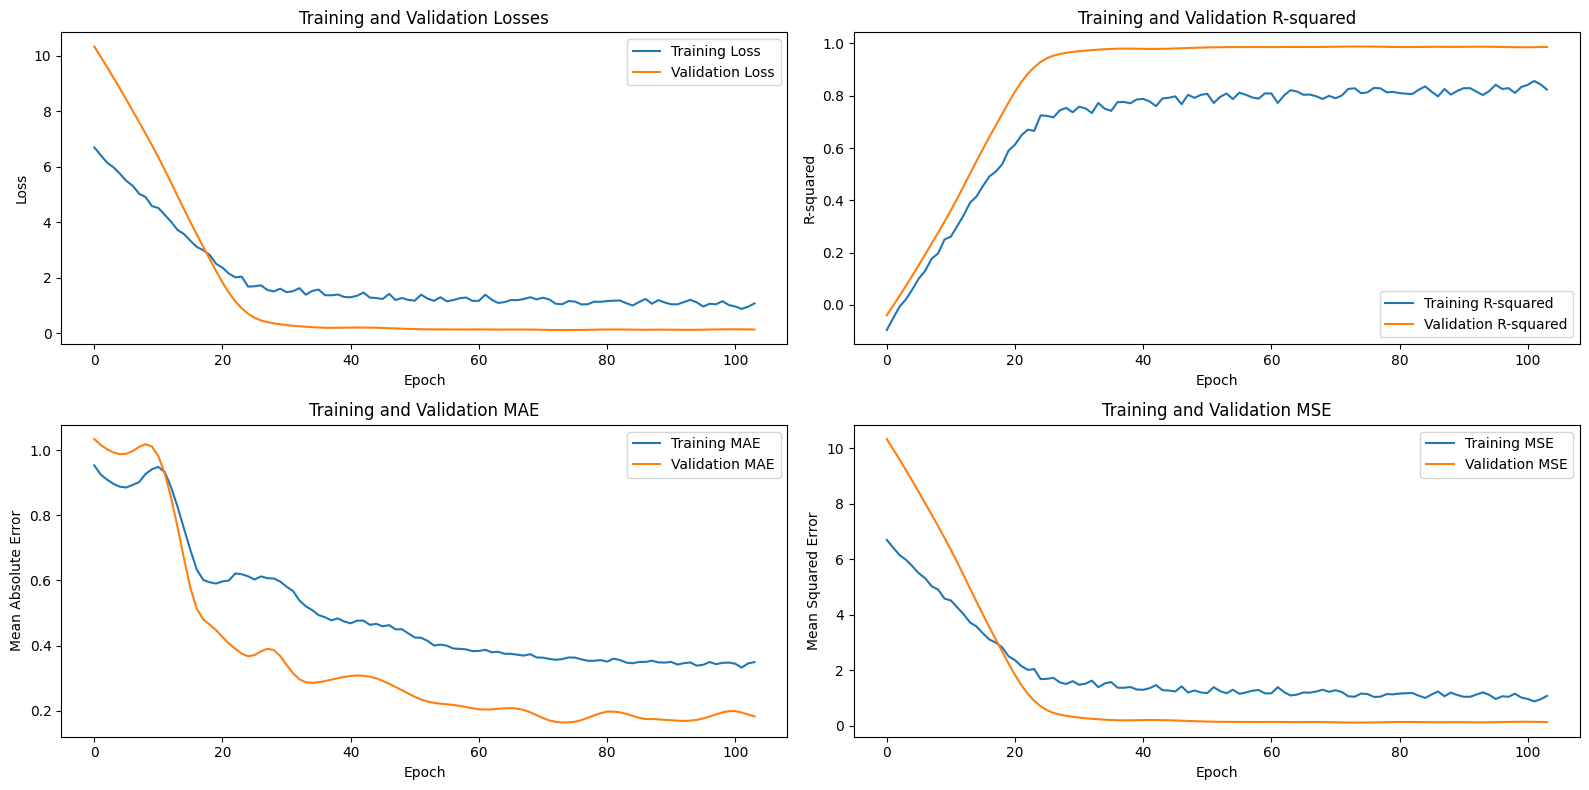

Test R-squared: 0.974297589896058, Test MAE: 13.586617469787598, Test MSE: 810.109619140625, Avg Test Residual: 4.4996562004089355


In [42]:
from sklearn.preprocessing import RobustScaler
import torch
from torch import optim
from torch_geometric.nn import SAGEConv
import joblib
import os
import optuna
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
os.makedirs(drive_path, exist_ok=True)
model_path = os.path.join(drive_path, 'pegnn_model_ROME.pth')
study_path = os.path.join(drive_path, 'optuna_study_pegnn_ROME.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_ROME.pkl')

# Function to save and load the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, in_channels, hidden_channels):
    model = model_class(in_channels, hidden_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to save and load input feature size
def save_input_feature_size(size, path):
    with open(path, 'wb') as f:
        joblib.dump(size, f)

def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Create edges using k-nearest neighbors
def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

# Learnable Positional Embeddings
class PositionalEncoding(torch.nn.Module):
    def __init__(self, num_positions, d_model):
        super(PositionalEncoding, self).__init__()
        self.position_embeddings = torch.nn.Parameter(torch.zeros(num_positions, d_model))

    def forward(self, positions):
        return self.position_embeddings[positions]

# PEGNN model definition with a single fully connected layer
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout_rate=0.5):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.out = torch.nn.Linear(hidden_channels, 1)  # Single fully connected layer with one output node

    def forward(self, x, edge_index):
        price_index = 1
        prices = x[:, price_index]

        # Mask out the node's own price during aggregation
        x_masked = x.clone()
        x_masked[:, price_index] = 0

        # Pass through the first convolutional layer with dropout
        x = self.conv1(x_masked, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Pass through the second convolutional layer
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Directly pass to the final output layer
        x = self.out(x)

        return x

d_model = 128

# Optuna objective function
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    k = trial.suggest_int('k', 1, 150)  # Hyperparameter for k-nearest neighbors
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    edge_index_train = create_edges_knn(train_coords_pegnn, k)
    edge_index_val = create_edges_knn(val_coords_pegnn, k)
    edge_index_test = create_edges_knn(test_coords_pegnn, k)

    positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
    pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
    pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
    pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

    x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
    x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
    x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

    model = PEGNN(in_channels=x_train.shape[1], hidden_channels=hidden_channels, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization with weight_decay
    loss_fn = torch.nn.MSELoss()

    model.train()
    for epoch in tqdm(range(50), desc="Training PEGNN"):
        optimizer.zero_grad()
        out_train = model(x_train, edge_index_train)
        loss = loss_fn(out_train, y_train)
        loss.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)

    return val_loss.item()

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Save the study
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

best_params = study.best_params
print("Best parameters: ", best_params)

# Final training with best parameters
edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

# Save input feature size
input_feature_size = x_train.shape[1]
save_input_feature_size(input_feature_size, input_size_path)

model = PEGNN(in_channels=input_feature_size, hidden_channels=best_params['hidden_channels'], dropout_rate=best_params['dropout_rate'])
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)  # L2 regularization with weight_decay
loss_fn = torch.nn.MSELoss()

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
patience_counter = 0

model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        save_model(model, model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

    model.train()

# Plotting
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

# Rescale predictions and targets for final evaluation
model.eval()
with torch.no_grad():
    out_train = model(x_train, edge_index_train)
    out_val = model(x_val, edge_index_val)
    out_test = model(x_test, edge_index_test)

# Inverse transform the predictions and actual values
out_train_rescaled = scaler.inverse_transform(out_train.numpy())
y_train_rescaled = scaler.inverse_transform(y_train.numpy())

out_val_rescaled = scaler.inverse_transform(out_val.numpy())
y_val_rescaled = scaler.inverse_transform(y_val.numpy())

out_test_rescaled = scaler.inverse_transform(out_test.numpy())
y_test_rescaled = scaler.inverse_transform(y_test.numpy())

# Compute metrics on the original scale
train_r2 = r2_score(y_train_rescaled, out_train_rescaled)
train_mae = mean_absolute_error(y_train_rescaled, out_train_rescaled)
train_mse = mean_squared_error(y_train_rescaled, out_train_rescaled)

val_r2 = r2_score(y_val_rescaled, out_val_rescaled)
val_mae = mean_absolute_error(y_val_rescaled, out_val_rescaled)
val_mse = mean_squared_error(y_val_rescaled, out_val_rescaled)

test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)
test_residuals_avg = np.mean(y_test_rescaled - out_test_rescaled)
print(f'Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}, Avg Test Residual: {test_residuals_avg}')


extra reporting metrics


Test Loss: 0.12579220533370972, Test R-squared: 0.974297589896058, Test MAE: 13.586617469787598, Test MSE: 810.109619140625


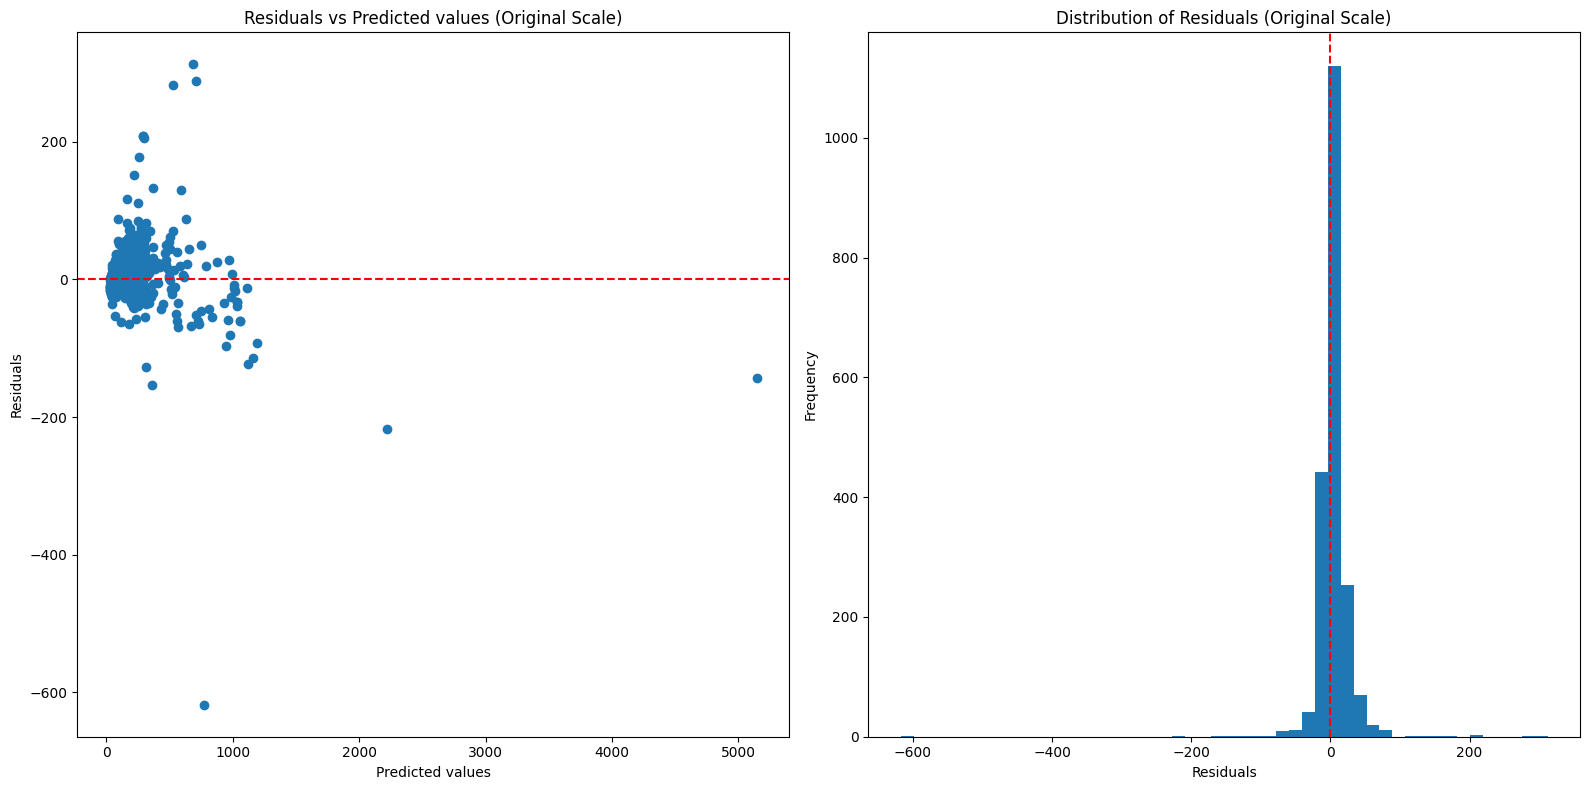

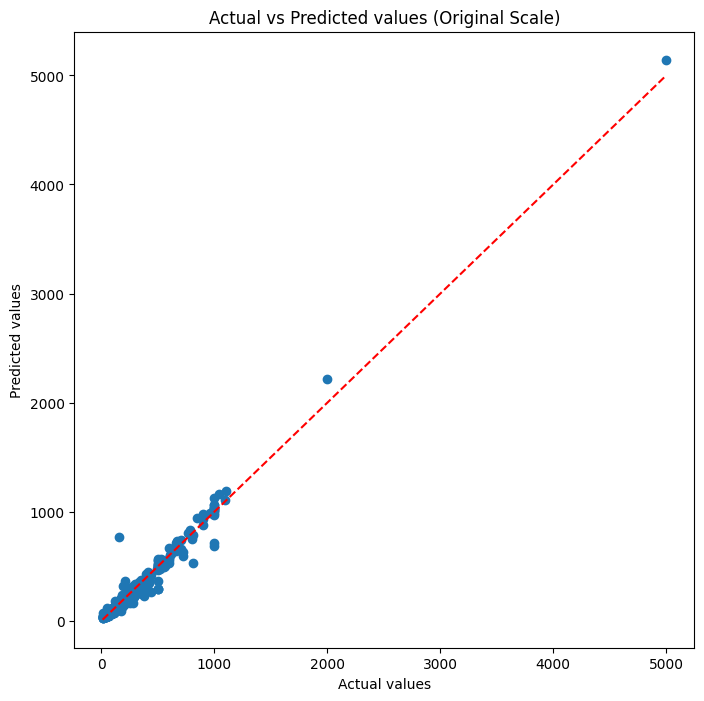

In [43]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()

# Inverse transform the predictions and actual values
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)

# Calculate evaluation metrics on the original scale
test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')

# Calculate residuals in the original scale
residuals_rescaled = y_test_rescaled - out_test_rescaled

# Plotting residuals
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(out_test_rescaled, residuals_rescaled)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values (Original Scale)')
plt.axhline(0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(residuals_rescaled, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Original Scale)')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Plotting predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_rescaled, out_test_rescaled)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values (Original Scale)')
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', linestyle='--')
plt.show()


Text(0.5, 1.0, 'Heatmap of Predicted Prices')

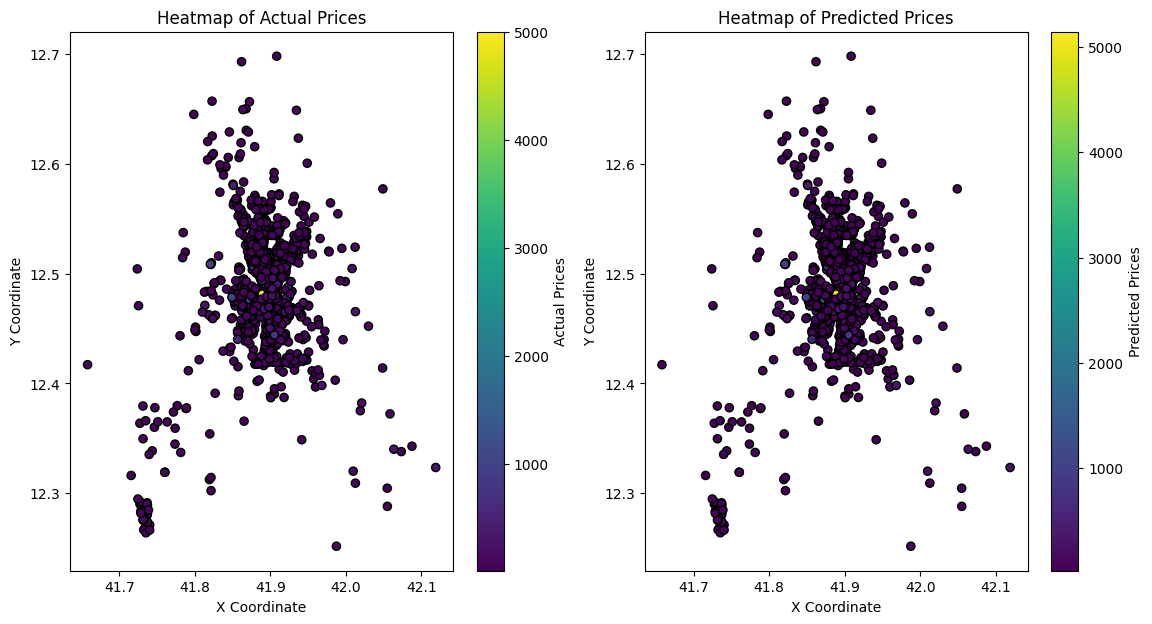

In [44]:
import seaborn as sns

# Assuming 'coords_np' contains the coordinates and 'scaler' is used for inverse transformation
coords_np = np.array(test_coords_pegnn)

# Rescale the actual and predicted prices to original scale
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)
residuals_rescaled = y_test_rescaled - out_test_rescaled

plt.figure(figsize=(21, 7))

# Heatmap of Actual Prices
plt.subplot(1, 3, 1)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=y_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Actual Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Actual Prices')

# Heatmap of Predicted Prices
plt.subplot(1, 3, 2)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=out_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Predicted Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Predicted Prices')


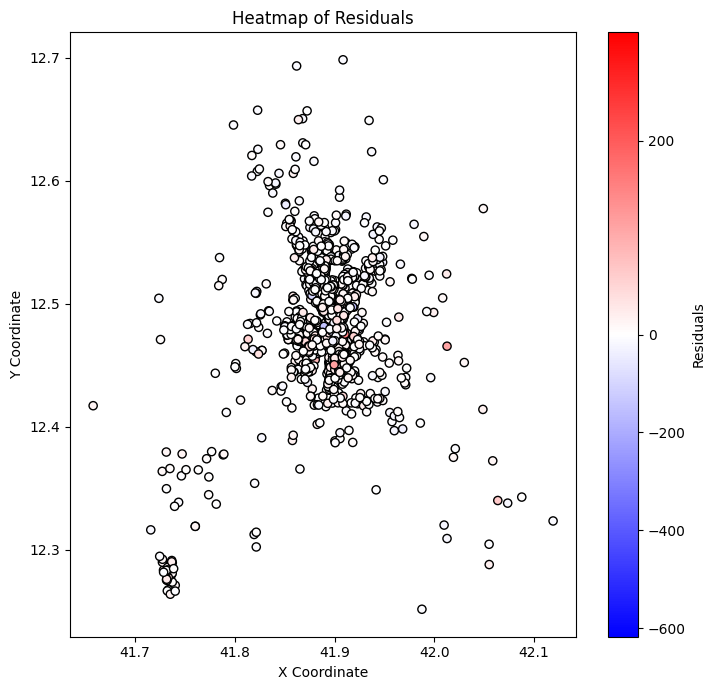

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm



# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(coords_np[:, 0], coords_np[:, 1], c=residuals_rescaled.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals')

plt.tight_layout()
plt.show()


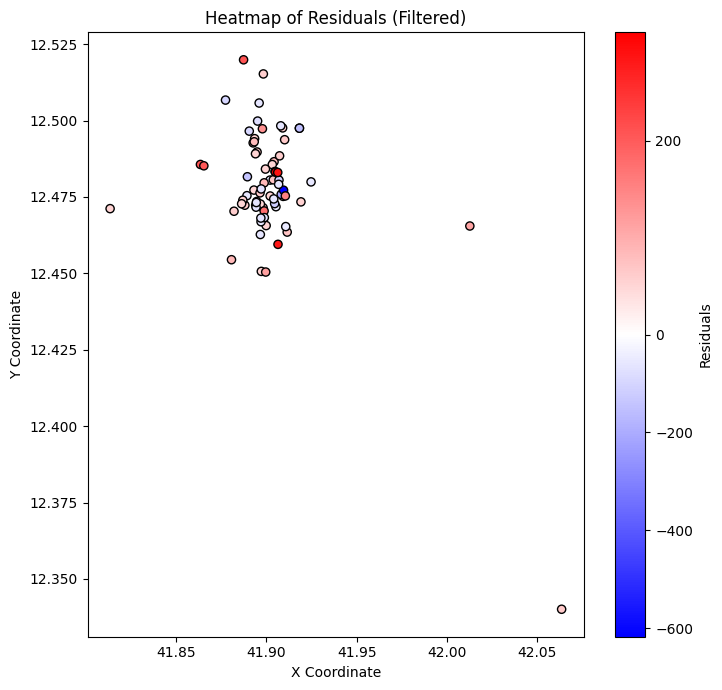

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Assuming residuals_rescaled and coords_np are already defined

# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Filter out residuals between -50 and 50
mask = (residuals_rescaled < -50) | (residuals_rescaled > 50)
filtered_coords = coords_np[mask.flatten()]
filtered_residuals = residuals_rescaled[mask]

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], c=filtered_residuals.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals (Filtered)')

plt.tight_layout()
plt.show()


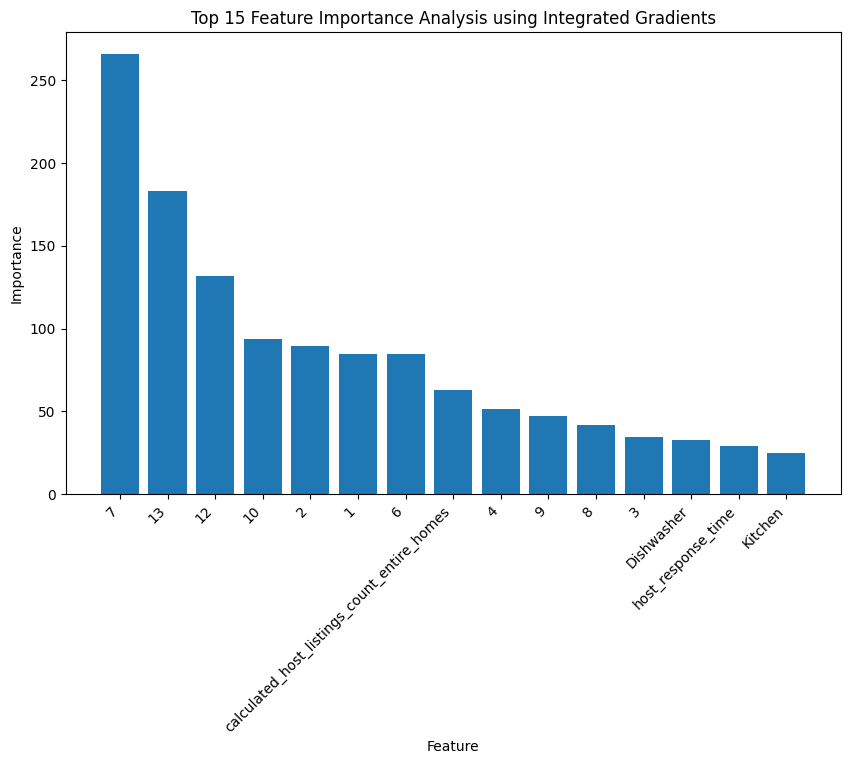

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Assuming model, x_test, edge_index_test, y_test, and feature_names are already defined

inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, top_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()


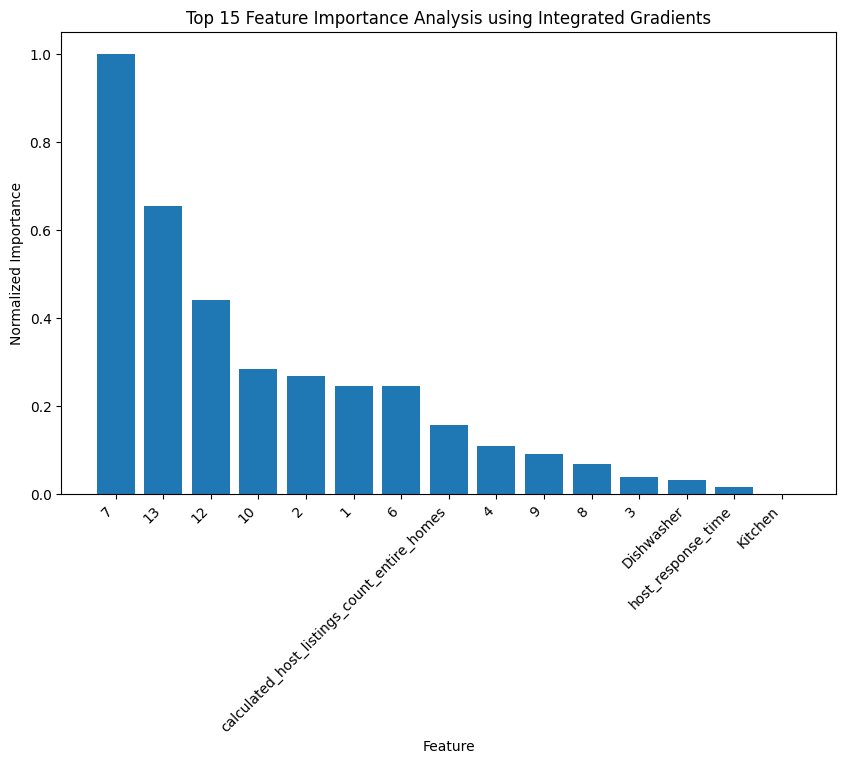

Top 15 Feature Importances (Normalized):
7: 1.0000
13: 0.6557
12: 0.4421
10: 0.2851
2: 0.2680
1: 0.2467
6: 0.2464
calculated_host_listings_count_entire_homes: 0.1567
4: 0.1096
9: 0.0913
8: 0.0679
3: 0.0400
Dishwasher: 0.0320
host_response_time: 0.0158
Kitchen: 0.0000


In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# Assuming train_features_pegnn, model, x_test, edge_index_test, and y_test are already defined

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Get the inputs and baseline for the entire graph
inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)

# Compute Integrated Gradients for each node in the graph
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

# Summing up the attributions for all nodes to get overall feature importances
overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Normalize the top 15 feature importances to the range [0, 1]
min_importance = np.min(top_importances)
max_importance = np.max(top_importances)
normalized_importances = (top_importances - min_importance) / (max_importance - min_importance)

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, normalized_importances)
plt.xlabel('Feature')
plt.ylabel('Normalized Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()

# Create a DataFrame for the top 15 features and their normalized importances
feature_importances_df = pd.DataFrame({
    'Feature': top_features,
    'Normalized Importance': normalized_importances
})

# Save the DataFrame to a CSV file
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
feature_importances_df.to_csv(path + 'feature_importances_with_lstm_london.csv', index=False)
# Display the list of top 15 features with their normalized importances
print("Top 15 Feature Importances (Normalized):")
for feature, importance in zip(top_features, normalized_importances):
    print(f"{feature}: {importance:.4f}")